In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./all/train.csv')
test = pd.read_csv('./all/train.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
LotFrontage,259,259
Alley,1369,1369
MasVnrType,8,8
MasVnrArea,8,8
BsmtQual,37,37
BsmtCond,37,37
BsmtExposure,38,38
BsmtFinType1,37,37
BsmtFinType2,38,38
Electrical,1,1


In [5]:
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

In [6]:
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [7]:
train_labels = train.pop('SalePrice')

In [8]:
features = pd.concat([train, test], keys=['train', 'test'])
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 
               'MiscVal'],
              axis=1, inplace=True)

In [9]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [10]:
# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

In [11]:
features.isnull().sum()

Alley               0
BedroomAbvGr        0
BldgType            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinType2        0
BsmtQual            0
CentralAir          0
Condition1          0
Condition2          0
Electrical          0
ExterCond           0
ExterQual           0
Exterior1st         0
Exterior2nd         0
FireplaceQu         0
Fireplaces          0
Foundation          0
FullBath            0
GarageCars          0
GarageFinish        0
GarageQual          0
GarageType          0
GrLivArea           0
HalfBath            0
HeatingQC           0
HouseStyle          0
Id                  0
KitchenAbvGr        0
KitchenQual         0
LandContour         0
LandSlope           0
LotArea             0
LotConfig           0
LotFrontage         0
LotShape            0
MSSubClass          0
MSZoning            0
MasVnrType          0
MoSold              0
Neighborhood        0
OverallCond         0
OverallQual         0
PavedDrive          0
RoofStyle 

In [36]:
features.isna().describe

<bound method NDFrame.describe of             BedroomAbvGr  Fireplaces  FullBath  GarageCars  GrLivArea  \
train 0            False       False     False       False      False   
      1            False       False     False       False      False   
      2            False       False     False       False      False   
      3            False       False     False       False      False   
      4            False       False     False       False      False   
      5            False       False     False       False      False   
      6            False       False     False       False      False   
      7            False       False     False       False      False   
      8            False       False     False       False      False   
      9            False       False     False       False      False   
      10           False       False     False       False      False   
      11           False       False     False       False      False   
      12         

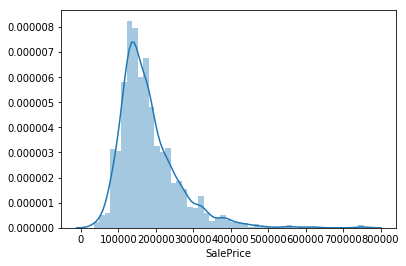

In [12]:
ax = sns.distplot(train_labels)

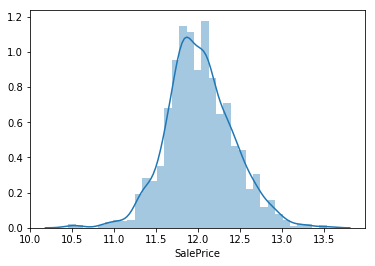

In [13]:
train_labels = np.log(train_labels)
ax = sns.distplot(train_labels)

In [14]:
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

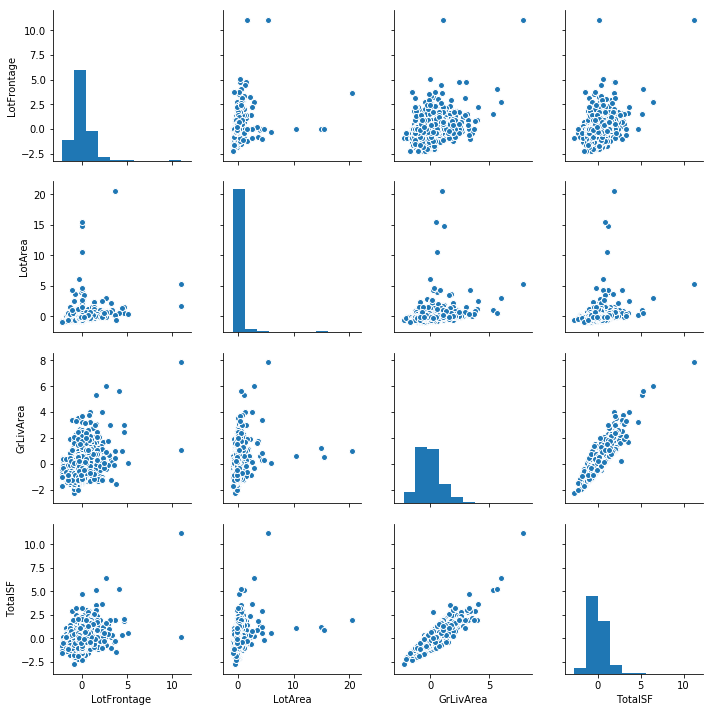

In [15]:
ax = sns.pairplot(numeric_features_standardized)

In [16]:
# Getting Dummies from Condition1 and Condition2
conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.ix[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

In [17]:
# Getting Dummies from Exterior1st and Exterior2nd
exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.ix[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

In [18]:
# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [19]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

In [20]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

In [21]:
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)

In [22]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.3, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

In [39]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], 
                                    max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [41]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NameError: name 'ENSTest' is not defined

In [42]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [43]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
Accuracy: 0.89 (+/- 0.04)

SyntaxError: invalid syntax (<ipython-input-43-2e452abcb87a>, line 4)

In [44]:
# Retraining models
GB_model = GBest.fit(train_features, train_labels)
ENST_model = ENSTest.fit(train_features_st, train_labels)

NameError: name 'GBest' is not defined

In [45]:
## Getting our SalePrice estimation
Final_labels = (np.exp(GB_model.predict(test_features)) + np.exp(ENST_model.predict(test_features_st))) / 2

NameError: name 'GB_model' is not defined

In [ ]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': Final_labels}).to_csv('2017-02-28.csv', index =False)    